# Constraint Programming (CP)

In [2]:
import utils.converter as convert
import utils.presenter as show
import utils.checker as check

In [3]:
import pandas as pd
# pip install ortools==9.8.3296
from ortools.sat.python import cp_model

In [4]:
import time

In [6]:
main_file_path = "../main_data/{}"

In [7]:
# Datei laden
with open(main_file_path.format("jobshop_instances.json"), "r", encoding="utf-8") as f:
    jobshop_instances = json.load(f)

instance =  jobshop_instances["instance ft10"]
df_instance = convert.jssp_dict_to_df(instance)
df_instance

,Job,Operation,Machine,Processing Time
0,job 0,0,M0,29
1,job 0,1,M1,78
2,job 0,2,M2,9
3,job 0,3,M3,36
4,job 0,4,M4,49
...,...,...,...,...
95,job 9,5,M9,76
96,job 9,6,M5,47
97,job 9,7,M3,52
98,job 9,8,M4,90


In [8]:
max_time = 60*15

In [9]:
import pandas as pd
from ortools.sat.python import cp_model


def solve_cp_jssp_makespan(df_jssp: pd.DataFrame, time_limit: int = 1200, msg: bool = False, gapRel: float = 0.0) -> pd.DataFrame:
    """
    Minimiert den Makespan eines klassischen Job-Shop-Problems (JSSP) mit einem CP-Modell.

    Parameter:
    - df_jssp: DataFrame mit Spalten ['Job','Operation','Machine','Processing Time'].
    - time_limit: Zeitlimit in Sekunden (Standard: 1200).
    - msg: Ausgabe des CP-Solvers aktivieren.
    - gapRel: Relatives Gap zur frühzeitigen Beendigung.

    Rückgabe:
    - df_schedule: Zeitplan mit Start- und Endzeiten sowie Maschinenbelegung.
    """

    model = cp_model.CpModel()

    # Vorbereitung
    jobs = sorted(df_jssp['Job'].unique())
    ops_grouped = df_jssp.sort_values(['Job', 'Operation']).groupby('Job')
    all_ops = []
    machines = set()

    for job in jobs:
        seq = []
        for _, row in ops_grouped.get_group(job).iterrows():
            op_id = int(row["Operation"])
            m = str(row["Machine"])
            d = int(round(row["Processing Time"]))
            seq.append((op_id, m, d))
            machines.add(m)
        all_ops.append(seq)

    horizon = int(df_jssp["Processing Time"].sum())

    # Variablen
    starts, ends, intervals = {}, {}, {}
    for j, job in enumerate(jobs):
        for o, (op_id, m, d) in enumerate(all_ops[j]):
            suffix = f"{j}_{o}"
            start = model.NewIntVar(0, horizon, f"start_{suffix}")
            end = model.NewIntVar(0, horizon, f"end_{suffix}")
            interval = model.NewIntervalVar(start, d, end, f"interval_{suffix}")
            starts[(j, o)] = start
            ends[(j, o)] = end
            intervals[(j, o)] = (interval, m)

    # Makespan-Variable
    makespan = model.NewIntVar(0, horizon, "makespan")
    for j, job in enumerate(jobs):
        last_op = len(all_ops[j]) - 1
        model.Add(ends[(j, last_op)] <= makespan)

    # Technologische Abfolge
    for j in range(len(jobs)):
        for o in range(1, len(all_ops[j])):
            model.Add(starts[(j, o)] >= ends[(j, o - 1)])

    # Maschinenrestriktionen
    for m in machines:
        machine_intervals = [intervals[(j, o)][0] for (j, o), (interval, mach) in intervals.items() if mach == m]
        model.AddNoOverlap(machine_intervals)

    # Zielfunktion
    model.Minimize(makespan)

    # Solver starten
    solver = cp_model.CpSolver()
    solver.parameters.max_time_in_seconds = time_limit
    solver.parameters.log_search_progress = msg
    solver.parameters.relative_gap_limit = gapRel

    status = solver.Solve(model)

    # Ergebnis extrahieren
    records = []
    if status in [cp_model.OPTIMAL, cp_model.FEASIBLE]:
        for j, job in enumerate(jobs):
            for o, (op_id, m, d) in enumerate(all_ops[j]):
                st = solver.Value(starts[(j, o)])
                ed = st + d
                records.append({
                    "Job": job,
                    "Operation": op_id,
                    "Machine": m,
                    "Start": st,
                    "Processing Time": d,
                    "End": ed
                })
        df_schedule = pd.DataFrame(records).sort_values(["Start", "Job", "Operation"]).reset_index(drop=True)
    else:
        print(f"\nSolver-Status     : {solver.StatusName(status)}")
        print("Keine zulässige Lösung gefunden.")
        df_schedule = pd.DataFrame()

    # Logging
    print("\nSolver-Informationen:")
    print(f"  Solver-Status    : {solver.StatusName(status)}")
    print(f"  Makespan         : {solver.ObjectiveValue()}")
    print(f"  Best Bound       : {solver.BestObjectiveBound()}")
    print(f"  Laufzeit         : {solver.WallTime():.2f} Sekunden")

    return df_schedule


### Scheduling

In [11]:
starting_time = time.time()

# Scheduling
df_plan = solve_cp_jssp_makespan(df_instance, msg=False, time_limit=max_time)

# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.1f} Sekunden.")
df_plan


Solver-Informationen:
  Solver-Status    : OPTIMAL
  Makespan         : 930.0
  Best Bound       : 930.0
  Laufzeit         : 13.91 Sekunden

Scheduling-Dauer: 0 Minuten und 13.9 Sekunden.


,Job,Operation,Machine,Start,Processing Time,End
0,job 5,0,M2,0,84,84
1,job 8,0,M0,0,76,76
2,job 3,0,M1,1,81,82
3,job 1,0,M0,76,43,119
4,job 5,1,M1,84,2,86
...,...,...,...,...,...,...
95,job 4,9,M6,857,53,910
96,job 9,9,M7,885,45,930
97,job 1,9,M8,886,30,916
98,job 2,9,M4,896,33,929


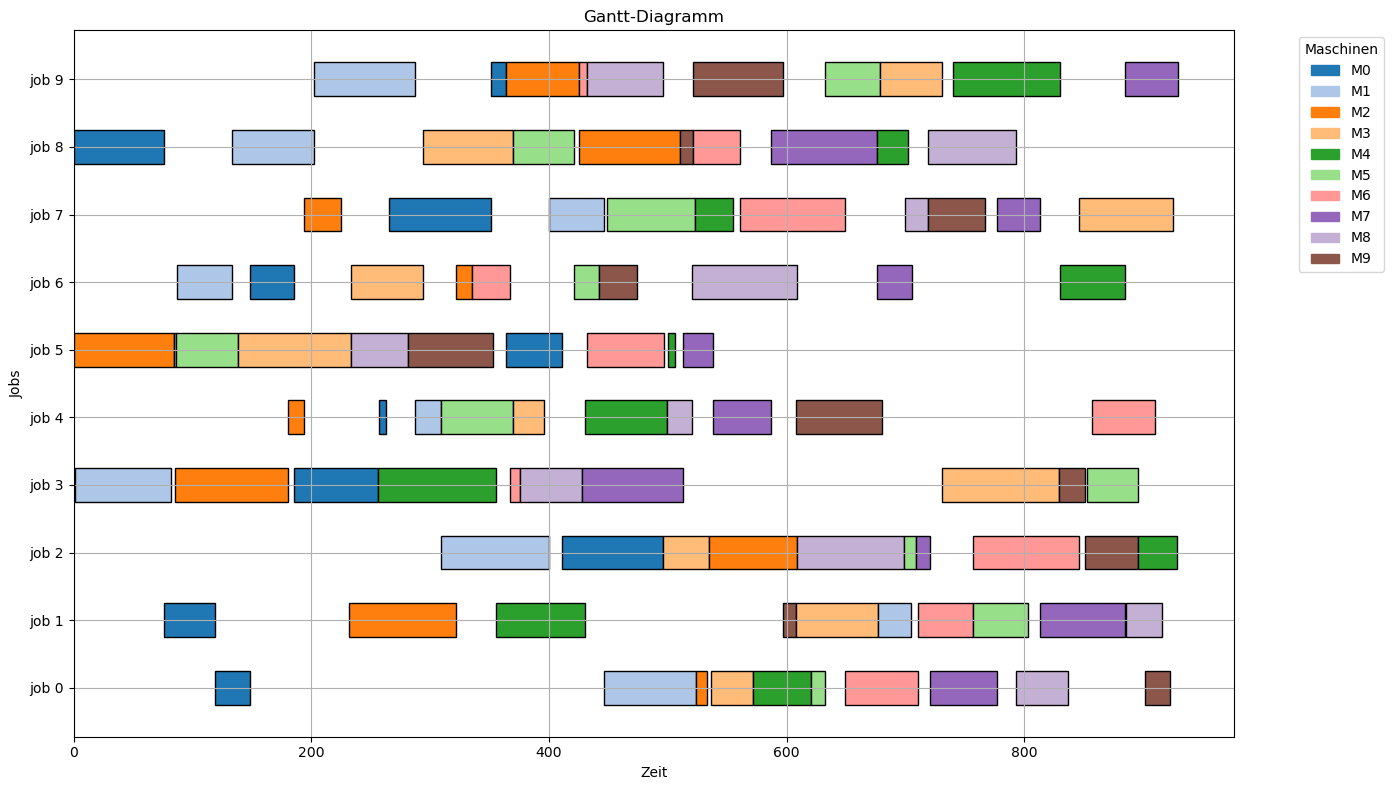

In [12]:
show.plot_gantt_jobs(df_plan)

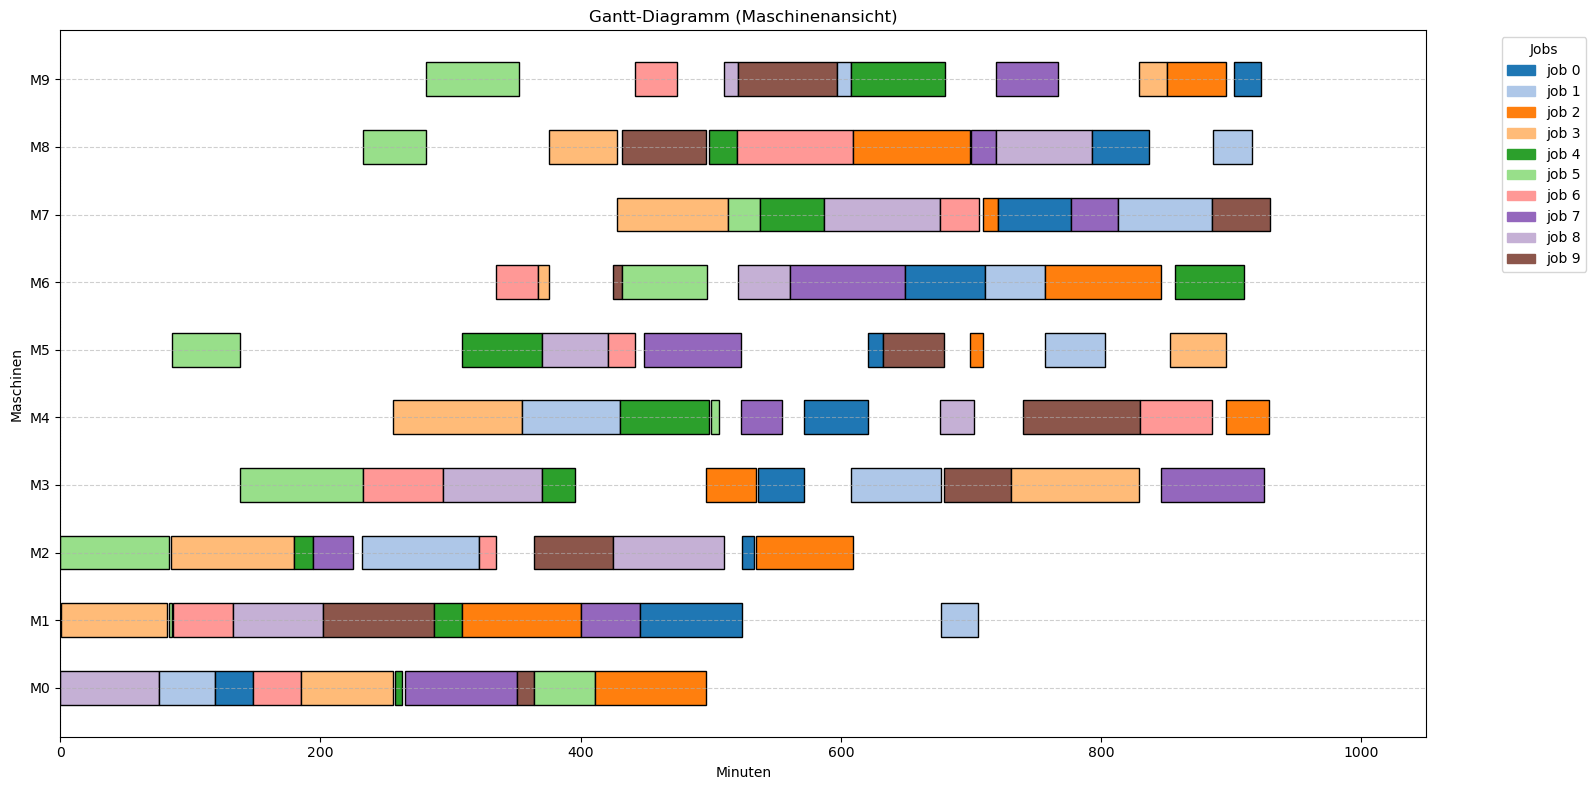

In [13]:
show.plot_gantt_machines(df_plan)

In [14]:
check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)

+ Keine Maschinenkonflikte gefunden
+ Für alle Jobs ist die Operationssequenz korrekt.
+ Zeitliche technologische Reihenfolge korrekt.


True